In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(1337)

In [3]:
import numpy as np

np.random.seed(1337)
input_image = np.random.randn(5, 7).astype(np.float32)
kernel = np.random.randn(3, 3).astype(np.float32)

In [5]:
np.sum(input_image[0:3, 0:3] * kernel)

-1.7359321

In [4]:
input_image_tensor = torch.tensor(
    np.expand_dims(np.expand_dims(input_image, 0), 0), dtype=torch.float32, requires_grad=True
)
kernel_tensor = torch.tensor(np.expand_dims(np.expand_dims(kernel, 0), 0), dtype=torch.float32, requires_grad=True)
output_tensor = F.conv2d(input_image_tensor, kernel_tensor)
output_tensor.retain_grad()
output_tensor

tensor([[[[-1.7359,  1.6481,  0.5012, -5.2333, -0.5101],
          [-1.5167,  3.7987,  0.8453, -3.0083, -2.9609],
          [-1.3546, -0.2310,  2.4693, -1.8407, -5.2685]]]],
       grad_fn=<ConvolutionBackward0>)

In [53]:
def conv2d(input, kernel):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    input_height, input_weight = input.shape
    kernel_height, kernel_weight = kernel.shape

    output_height = input_height - kernel_height + 1
    output_weight = input_weight - kernel_weight + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            output[i, j] = np.sum(input[i : i + kernel_height, j : j + kernel_weight] * kernel)

    return output

In [67]:
np.allclose(conv2d(input_image, kernel), output_tensor.data.squeeze(0).squeeze(0).numpy())

True

### Back Prop

In [68]:
loss = torch.sum(output_tensor)
loss

tensor(-14.3974, grad_fn=<SumBackward0>)

In [69]:
loss.backward()

In [44]:
output_tensor.grad.numpy()

array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]]], dtype=float32)

In [35]:
output_tensor.grad

tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]]])

In [48]:
np.sum(input_image[0:3, 0:5] * output_tensor.grad.squeeze(0).squeeze(0).numpy())

-0.533592963478067

In [38]:
kernel_tensor.grad

tensor([[[[-0.5336, -5.6544, -5.7220],
          [ 2.2203, -1.4431, -2.8828],
          [ 2.0596, -1.3358, -1.9492]]]])

In [71]:
# Gradients of conv is also a conv
conv2d(input_image, kernel=output_tensor.grad.squeeze(0).squeeze(0).numpy())

array([[-0.53359306, -5.65440559, -5.72200251],
       [ 2.2202642 , -1.44307494, -2.88277555],
       [ 2.05961275, -1.33583522, -1.94924402]])

In [72]:
kernel_tensor.grad.squeeze(0).squeeze(0).numpy()

array([[-0.5335932, -5.6544065, -5.7220025],
       [ 2.220264 , -1.4430748, -2.8827758],
       [ 2.0596128, -1.3358345, -1.9492438]], dtype=float32)

In [73]:
np.allclose(
    conv2d(input_image, kernel=output_tensor.grad.squeeze(0).squeeze(0).numpy()),
    kernel_tensor.grad.squeeze(0).squeeze(0).numpy(),
)

True

### Strides

In [93]:
F.conv2d(input_image_tensor, kernel_tensor, stride=2, padding=0)

tensor([[[[-1.7359,  0.5012, -0.5101],
          [-1.3546,  2.4693, -5.2685]]]], grad_fn=<ConvolutionBackward0>)

In [103]:
import numpy as np
import typing as tp


def conv2d(input, kernel, stride: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    if not stride:
        stride_height = stride_weight = 1
    elif isinstance(stride, int):
        stride_height = stride_weight = stride
    else:
        assert len(stride) == 2
        stride_height, stride_weight = stride

    input_height, input_weight = input.shape
    kernel_height, kernel_weight = kernel.shape

    # Adjust output size based on strides
    output_height = int(np.floor((input_height - kernel_height) / stride_height)) + 1
    output_weight = int(np.floor((input_weight - kernel_weight) / stride_weight)) + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            # For stride, the only difference is the starting point.
            row = i * stride_height
            col = j * stride_weight
            output[i, j] = np.sum(input[row : row + kernel_height, col : col + kernel_weight] * kernel)

    return output

In [104]:
# Default is no stride
np.allclose(
    conv2d(input_image, kernel),
    F.conv2d(input_image_tensor, kernel_tensor, stride=1).data.squeeze(0).squeeze(0).numpy(),
)

True

In [105]:
np.allclose(
    conv2d(input_image, kernel, stride=2),
    F.conv2d(input_image_tensor, kernel_tensor, stride=2).data.squeeze(0).squeeze(0).numpy(),
)

True

In [106]:
np.allclose(
    conv2d(input_image, kernel, stride=(1, 3)),
    F.conv2d(input_image_tensor, kernel_tensor, stride=(1, 3)).data.squeeze(0).squeeze(0).numpy(),
)

True

In [131]:
# Extreme Cases
np.allclose(
    conv2d(input_image, kernel, stride=5),
    F.conv2d(input_image_tensor, kernel_tensor, stride=5).data.squeeze(0).squeeze(0).numpy(),
)

True

### Padding

In [102]:
F.conv2d(input_image_tensor, kernel_tensor, stride=1, padding=1)

tensor([[[[-0.4119, -3.3077, -1.5374, -0.9443, -3.7461, -0.1400, -0.9590],
          [-1.4036, -1.7359,  1.6481,  0.5012, -5.2333, -0.5101,  2.8364],
          [-0.2356, -1.5167,  3.7987,  0.8453, -3.0083, -2.9609,  2.5304],
          [-2.5582, -1.3546, -0.2310,  2.4693, -1.8407, -5.2685, -1.3589],
          [-1.6277,  0.9669,  0.7669,  1.8226, -0.4189, -2.9021, -0.7838]]]],
       grad_fn=<ConvolutionBackward0>)

In [110]:
a = np.array([[1, 2, 3], [4, 5, 6]])
np.pad(a, ((2,), (1,)))

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 2, 3, 0],
       [0, 4, 5, 6, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [120]:
def conv2d(input, kernel, padding: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    if not padding:
        padding_height = padding_weight = 0
    elif isinstance(padding, int):
        padding_height = padding_weight = padding
    else:
        assert len(padding) == 2
        padding_height, padding_weight = padding

    # Pad input
    input = np.pad(input, ((padding_height,), (padding_weight,)), mode="constant", constant_values=(0, 0))

    input_height, input_weight = input.shape
    kernel_height, kernel_weight = kernel.shape

    output_height = input_height - kernel_height + 1
    output_weight = input_weight - kernel_weight + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            output[i, j] = np.sum(input[i : i + kernel_height, j : j + kernel_weight] * kernel)

    return output

In [121]:
np.allclose(
    conv2d(input_image, kernel),
    F.conv2d(input_image_tensor, kernel_tensor).data.squeeze(0).squeeze(0).numpy(),
)

True

In [122]:
np.allclose(
    conv2d(input_image, kernel, padding=1),
    F.conv2d(input_image_tensor, kernel_tensor, padding=1).data.squeeze(0).squeeze(0).numpy(),
)

True

In [123]:
np.allclose(
    conv2d(input_image, kernel, padding=(2, 1)),
    F.conv2d(input_image_tensor, kernel_tensor, padding=(2, 1)).data.squeeze(0).squeeze(0).numpy(),
)

True

In [130]:
# Extreme cases
np.allclose(
    conv2d(input_image, kernel, padding=4),
    F.conv2d(input_image_tensor, kernel_tensor, padding=4).data.squeeze(0).squeeze(0).numpy(),
)

True

### Padding + Stride

In [154]:
import numpy as np
import typing as tp


def conv2d(
    input,
    kernel,
    stride: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
    padding: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    # Stride
    if not stride:
        stride_height = stride_weight = 1
    elif isinstance(stride, int):
        stride_height = stride_weight = stride
    else:
        assert len(stride) == 2
        stride_height, stride_weight = stride

    # Pad input
    if not padding:
        padding_height = padding_weight = 0
    elif isinstance(padding, int):
        padding_height = padding_weight = padding
    else:
        assert len(padding) == 2
        padding_height, padding_weight = padding

    input = np.pad(input, ((padding_height,), (padding_weight,)), mode="constant", constant_values=(0, 0))

    input_height, input_weight = input.shape
    kernel_height, kernel_weight = kernel.shape

    # Output size
    output_height = int(np.floor((input_height - kernel_height) / stride_height)) + 1
    output_weight = int(np.floor((input_weight - kernel_weight) / stride_weight)) + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            row = i * stride_height
            col = j * stride_weight
            output[i, j] = np.sum(input[row : row + kernel_height, col : col + kernel_weight] * kernel)

    return output

In [155]:
np.allclose(
    conv2d(input_image, kernel),
    F.conv2d(input_image_tensor, kernel_tensor).data.squeeze(0).squeeze(0).numpy(),
)

True

In [156]:
np.allclose(
    conv2d(input_image, kernel, stride=2, padding=1),
    F.conv2d(input_image_tensor, kernel_tensor, stride=2, padding=1).data.squeeze(0).squeeze(0).numpy(),
)

True

In [157]:
np.allclose(
    conv2d(input_image, kernel, stride=(1, 3), padding=(2, 1)),
    F.conv2d(input_image_tensor, kernel_tensor, stride=(1, 3), padding=(2, 1)).data.squeeze(0).squeeze(0).numpy(),
)

True

### Padding Mode

In [158]:
import numpy as np
import typing as tp


def conv2d(
    input,
    kernel,
    stride: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
    padding: tp.Optional[tp.Union[int, tp.Tuple[int, int], str]] = None,
):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    # Stride
    if not stride:
        stride_height = stride_weight = 1
    elif isinstance(stride, int):
        stride_height = stride_weight = stride
    else:
        assert len(stride) == 2
        stride_height, stride_weight = stride

    # Pad input
    # Use 4 parameters for padding to deal with imbalanced cases.
    kernel_height, kernel_weight = kernel.shape

    if not padding:
        padding_up = padding_down = padding_left = padding_right = 0
    elif isinstance(padding, str):
        if padding == "valid":
            padding_up = padding_down = padding_left = padding_right = 0
        elif padding == "same":
            assert stride_height == 1 and stride_weight == 1, "'same' padding can only be applied to stride == 1."
            # new_input_height == input_height + 2 * pad
            # output_height = new_input_height - kernel_height + 1
            # We want output_height == input_height
            # Thus, new_input_height - kernel_height + 1 == new_input_height - 2 * pad
            # 2 * pad == kernel_height - 1, w.r.t pad is integer.
            # In case of imbalance, we pad more in 'down' and 'right'.
            padding_up = int(np.floor((kernel_height - 1) / 2))
            padding_down = int(np.ceil((kernel_height - 1) / 2))
            padding_left = int(np.floor((kernel_weight - 1) / 2))
            padding_right = int(np.ceil((kernel_weight - 1) / 2))

        elif padding == "full":
            padding_up = padding_down = kernel_height - 1
            padding_left = padding_right = kernel_weight - 1
        else:
            raise Exception(f"{padding} is not recognized. Can only be 'valid' or 'same' or 'full'.")

    elif isinstance(padding, int):
        padding_up = padding_down = padding_left = padding_right = padding
    else:
        assert len(padding) == 2
        padding_up = padding_down = padding[0]
        padding_left = padding_right = padding[1]

    input = np.pad(
        input, ((padding_up, padding_down), (padding_left, padding_right)), mode="constant", constant_values=(0, 0)
    )
    input_height, input_weight = input.shape

    output_height = int(np.floor((input_height - kernel_height) / stride_height)) + 1
    output_weight = int(np.floor((input_weight - kernel_weight) / stride_weight)) + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            row = i * stride_height
            col = j * stride_weight
            output[i, j] = np.sum(input[row : row + kernel_height, col : col + kernel_weight] * kernel)

    return output

In [159]:
np.allclose(
    conv2d(input_image, kernel, stride=2, padding="valid"),
    F.conv2d(input_image_tensor, kernel_tensor, stride=2, padding="valid").data.squeeze(0).squeeze(0).numpy(),
)

True

In [160]:
np.allclose(
    conv2d(input_image, kernel, stride=1, padding="same"),
    F.conv2d(input_image_tensor, kernel_tensor, stride=1, padding="same").data.squeeze(0).squeeze(0).numpy(),
)

True

In [161]:
np.allclose(
    conv2d(input_image, kernel, stride=1, padding="full"),
    F.conv2d(input_image_tensor, kernel_tensor, stride=1, padding=(kernel.shape[0] - 1, kernel.shape[1] - 1))
    .data.squeeze(0)
    .squeeze(0)
    .numpy(),
)

True

In [162]:
np.allclose(
    conv2d(input_image, kernel, stride=2, padding="full"),
    F.conv2d(input_image_tensor, kernel_tensor, stride=2, padding=(kernel.shape[0] - 1, kernel.shape[1] - 1))
    .data.squeeze(0)
    .squeeze(0)
    .numpy(),
)

True

### Dilation

In [7]:
kernel

array([[-0.00874653,  0.3670187 ,  1.1185547 ],
       [-0.00838993,  0.4663154 ,  1.2632687 ],
       [-0.90165466, -1.0288427 ,  0.5696784 ]], dtype=float32)

In [11]:
np.sum(input_image[:5:2, :5:2] * kernel)

0.5725032

In [8]:
F.conv2d(input_image_tensor, kernel_tensor, dilation=2)

tensor([[[[ 0.5725, -3.7247, -4.1936]]]], grad_fn=<ConvolutionBackward0>)

In [12]:
F.conv2d(input_image_tensor, kernel_tensor, dilation=5)

RuntimeError: Calculated padded input size per channel: (5 x 7). Kernel size: (11 x 11). Kernel size can't be greater than actual input size

In [20]:
dilation_height = dilation_weight = 2
kernel_height, kernel_weight = kernel.shape
dilated_kernel = np.zeros(
    (
        kernel_height + (dilation_height - 1) * (kernel_height - 1),
        kernel_weight + (dilation_weight - 1) * (kernel_weight - 1),
    )
)
for i in range(0, kernel_height):
    for j in range(0, kernel_weight):
        dilated_kernel[i * dilation_height, j * dilation_weight] = kernel[i, j]

dilated_kernel

array([[-0.00874653,  0.        ,  0.3670187 ,  0.        ,  1.11855471],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00838993,  0.        ,  0.46631539,  0.        ,  1.26326871],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.90165466,  0.        , -1.02884269,  0.        ,  0.56967843]])

In [23]:
import typing as tp


def conv2d(input, kernel, dilation: tp.Optional[tp.Union[int, tp.Tuple[int, int]]]):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    if not dilation:
        dilation_height = dilation_weight = 1
    elif isinstance(dilation, int):
        dilation_height = dilation_weight = dilation
    else:
        assert len(dilation) == 2
        dilation_height, dilation_weight = dilation

    # Pad kernel
    kernel_height, kernel_weight = kernel.shape
    dilated_kernel_height = kernel_height + (dilation_height - 1) * (kernel_height - 1)
    dilated_kernel_weight = kernel_weight + (dilation_weight - 1) * (kernel_weight - 1)
    dilated_kernel = np.zeros((dilated_kernel_height, dilated_kernel_weight))
    for i in range(0, kernel_height):
        for j in range(0, kernel_weight):
            dilated_kernel[i * dilation_height, j * dilation_weight] = kernel[i, j]

    input_height, input_weight = input.shape

    output_height = input_height - dilated_kernel_height + 1
    output_weight = input_weight - dilated_kernel_weight + 1
    if output_height < 1 or output_weight < 1:
        raise Exception("Kernel size cannot be larger then the input size.")

    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            output[i, j] = np.sum(input[i : i + dilated_kernel_height, j : j + dilated_kernel_weight] * dilated_kernel)

    return output

In [25]:
np.allclose(
    conv2d(input_image, kernel, dilation=2),
    F.conv2d(input_image_tensor, kernel_tensor, dilation=2).data.squeeze(0).squeeze(0).numpy(),
)

True

In [26]:
np.allclose(
    conv2d(input_image, kernel, dilation=(1, 3)),
    F.conv2d(input_image_tensor, kernel_tensor, dilation=(1, 3)).data.squeeze(0).squeeze(0).numpy(),
)

True

### Stride + Padding + Dilation

In [33]:
def dilate(kernel, dilation):
    if not dilation:
        dilation_height = dilation_weight = 1
    elif isinstance(dilation, int):
        dilation_height = dilation_weight = dilation
    else:
        assert len(dilation) == 2
        dilation_height, dilation_weight = dilation

    kernel_height, kernel_weight = kernel.shape
    dilated_kernel = np.zeros(
        (
            kernel_height + (dilation_height - 1) * (kernel_height - 1),
            kernel_weight + (dilation_weight - 1) * (kernel_weight - 1),
        )
    )
    for i in range(0, kernel_height):
        for j in range(0, kernel_weight):
            dilated_kernel[i * dilation_height, j * dilation_weight] = kernel[i, j]

    return dilated_kernel

array([[ 0.56798711,  0.        ,  0.        ,  0.30438786],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.0000296 ,  0.        ,  0.        , -2.45641783]])

In [55]:
import numpy as np
import typing as tp


def get_strides(stride: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None):
    if not stride:
        stride_height = stride_weight = 1
    elif isinstance(stride, int):
        stride_height = stride_weight = stride
    else:
        assert len(stride) == 2
        stride_height, stride_weight = stride
    return stride_height, stride_weight


def dilate(
    kernel,
    dilation: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
):
    if not dilation:
        dilation_height = dilation_weight = 1
    elif isinstance(dilation, int):
        dilation_height = dilation_weight = dilation
    else:
        assert len(dilation) == 2
        dilation_height, dilation_weight = dilation

    kernel_height, kernel_weight = kernel.shape
    dilated_kernel = np.zeros(
        (
            kernel_height + (dilation_height - 1) * (kernel_height - 1),
            kernel_weight + (dilation_weight - 1) * (kernel_weight - 1),
        )
    )
    for i in range(0, kernel_height):
        for j in range(0, kernel_weight):
            dilated_kernel[i * dilation_height, j * dilation_weight] = kernel[i, j]

    return dilated_kernel


def pad(
    input,
    kernel_height: int,
    kernel_weight: int,
    stride_height: int,
    stride_weight: int,
    padding: tp.Optional[tp.Union[int, tp.Tuple[int, int], str]] = None,
):
    if not padding:
        padding_up = padding_down = padding_left = padding_right = 0
    elif isinstance(padding, str):
        if padding == "valid":
            padding_up = padding_down = padding_left = padding_right = 0
        elif padding == "same":
            assert stride_height == 1 and stride_weight == 1, "'same' padding can only be applied to stride == 1."
            # new_input_height == input_height + 2 * pad
            # output_height = new_input_height - kernel_height + 1
            # We want output_height == input_height
            # Thus, new_input_height - kernel_height + 1 == new_input_height - 2 * pad
            # 2 * pad == kernel_height - 1, w.r.t pad is integer.
            # In case of imbalance, we pad more in 'down' and 'right'.
            padding_up = int(np.floor((kernel_height - 1) / 2))
            padding_down = int(np.ceil((kernel_height - 1) / 2))
            padding_left = int(np.floor((kernel_weight - 1) / 2))
            padding_right = int(np.ceil((kernel_weight - 1) / 2))

        elif padding == "full":
            padding_up = padding_down = kernel_height - 1
            padding_left = padding_right = kernel_weight - 1
        else:
            raise Exception(f"{padding} is not recognized. Can only be 'valid' or 'same' or 'full'.")

    elif isinstance(padding, int):
        padding_up = padding_down = padding_left = padding_right = padding
    else:
        assert len(padding) == 2
        padding_up = padding_down = padding[0]
        padding_left = padding_right = padding[1]

    padded_input = np.pad(
        input, ((padding_up, padding_down), (padding_left, padding_right)), mode="constant", constant_values=(0, 0)
    )
    return padded_input


def conv2d(
    input,
    kernel,
    stride: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
    padding: tp.Optional[tp.Union[int, tp.Tuple[int, int], str]] = None,
    dilation: tp.Optional[tp.Union[int, tp.Tuple[int, int]]] = None,
):
    assert len(input.shape) == 2
    assert len(kernel.shape) == 2

    # Stride
    stride_height, stride_weight = get_strides(stride)

    # Dilate Kernel
    kernel = dilate(kernel, dilation)
    kernel_height, kernel_weight = kernel.shape

    # Pad Input
    input = pad(input, kernel_height, kernel_weight, stride_height, stride_weight, padding)
    input_height, input_weight = input.shape

    # Output
    output_height = int(np.floor((input_height - kernel_height) / stride_height)) + 1
    output_weight = int(np.floor((input_weight - kernel_weight) / stride_weight)) + 1
    output = np.zeros((output_height, output_weight))

    for i in range(0, output_height):
        for j in range(0, output_weight):
            row = i * stride_height
            col = j * stride_weight
            output[i, j] = np.sum(input[row : row + kernel_height, col : col + kernel_weight] * kernel)

    return output

In [56]:
np.allclose(
    conv2d(input_image, kernel),
    F.conv2d(input_image_tensor, kernel_tensor).data.squeeze(0).squeeze(0),
)

True

In [60]:
np.allclose(
    conv2d(input_image, kernel, stride=(2, 3)),
    F.conv2d(input_image_tensor, kernel_tensor, stride=(2, 3)).data.squeeze(0).squeeze(0),
)

True

In [61]:
np.allclose(
    conv2d(input_image, kernel, stride=(2, 3), padding=(1, 2)),
    F.conv2d(input_image_tensor, kernel_tensor, stride=(2, 3), padding=(1, 2)).data.squeeze(0).squeeze(0),
)

True

In [62]:
np.allclose(
    conv2d(input_image, kernel, stride=(2, 3), padding=(1, 2), dilation=(1, 3)),
    F.conv2d(input_image_tensor, kernel_tensor, stride=(2, 3), padding=(1, 2), dilation=(1, 3))
    .data.squeeze(0)
    .squeeze(0),
)

True

In [57]:
np.allclose(
    conv2d(input_image, kernel, padding="same"),
    F.conv2d(input_image_tensor, kernel_tensor, padding="same").data.squeeze(0).squeeze(0),
)

True

In [58]:
np.allclose(
    conv2d(input_image, kernel, padding="same", dilation=2),
    F.conv2d(input_image_tensor, kernel_tensor, padding="same", dilation=2).data.squeeze(0).squeeze(0),
)

True

In [59]:
np.allclose(
    conv2d(input_image, kernel, padding="same", dilation=(2, 3)),
    F.conv2d(input_image_tensor, kernel_tensor, padding="same", dilation=(2, 3)).data.squeeze(0).squeeze(0),
)

True

In [65]:
np.allclose(
    conv2d(input_image, kernel, stride=(2, 3), padding="full"),
    F.conv2d(
        input_image_tensor,
        kernel_tensor,
        stride=(2, 3),
        padding=(kernel_tensor.shape[2] - 1, kernel_tensor.shape[3] - 1),
    )
    .data.squeeze(0)
    .squeeze(0),
)

True

### Back Prop with Stride / Padding / Dilation

In [101]:
output_tensor = F.conv2d(input_image_tensor, kernel_tensor, stride=(2, 3), padding=(1, 2), dilation=(1, 3))
output_tensor.retain_grad()
print(output_tensor.shape)
output_tensor

torch.Size([1, 1, 3, 2])


tensor([[[[-1.7203, -1.0085],
          [ 2.1243,  1.4154],
          [ 1.3350,  0.6755]]]], grad_fn=<ConvolutionBackward0>)

In [102]:
kernel_tensor.grad = None
input_image_tensor.grad = None
loss = torch.sum(output_tensor)
loss.backward()

In [103]:
output_tensor.grad

tensor([[[[1., 1.],
          [1., 1.],
          [1., 1.]]]])

In [104]:
kernel_tensor.grad

tensor([[[[ 0.2342,  0.0754, -0.1588],
          [-2.1738,  0.3401,  2.5139],
          [ 0.2342,  0.0754, -0.1588]]]])

In [105]:
output_grad = output_tensor.grad.squeeze(0).squeeze(0).numpy()
# Gradients of conv is also a conv
# stride in forward pass => dilation in backward pass
# dilation in forward pass => stride in backward pass
# padding in forward pass => padding in backward pass
conv2d(input_image, output_grad, stride=(1, 3), padding=(1, 2), dilation=(2, 3))

array([[ 0.23418331,  0.07538714, -0.15879618],
       [-2.17378468,  0.3401105 ,  2.51389518],
       [ 0.23418331,  0.07538714, -0.15879618]])

In [106]:
np.allclose(
    conv2d(input_image, output_grad, stride=(1, 3), padding=(1, 2), dilation=(2, 3)),
    kernel_tensor.grad.squeeze(0).squeeze(0).numpy(),
)

True

### Matplotlib

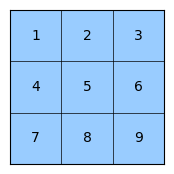

In [113]:
# Color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

light_blue = [0.6, 0.8, 1.0]  # RGB values for light blue
cmap = ListedColormap([light_blue])

fig, ax = plt.subplots()
fig.set_size_inches(2, 2)
im = ax.imshow(matrix, cmap=cmap)
ax.axhline(0.5, color="black", linestyle="-", linewidth=0.5)
ax.axhline(1.5, color="black", linestyle="-", linewidth=0.5)
ax.axvline(0.5, color="black", linestyle="-", linewidth=0.5)
ax.axvline(1.5, color="black", linestyle="-", linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

# Add text annotations
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, str(matrix[i, j]), ha="center", va="center", color="black")

plt.show()